In [1]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.feature_selection \
        import mutual_info_regression
        
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
import dask.dataframe as dd

# Define file path
FILE_PATH = "/home/sayem/Desktop/Project/data/dataset.h5"

# FILE_NAME = '/data/reduced_2022-07-21_to_2022-07-29'

FILE_NAME = '/data/2020-01-02_to_2022-12-30'

# Read the dataset using Dask
data = dd.read_hdf(FILE_PATH, FILE_NAME)

# Compute the result (this will load data into memory)
result = data.compute()

In [4]:
result.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4191516 entries, ('AA', Timestamp('2020-01-02 00:00:00')) to ('ZTS', Timestamp('2022-12-30 00:00:00'))
Columns: 624 entries, OPEN to ALPHA_101
dtypes: float32(384), float64(33), int32(198), int8(9)
memory usage: 10.2+ GB


In [5]:
# import pandas as pd
# import numpy as np
# from joblib import Parallel, delayed
# from utils import optimize_dataframe

# def compute_correlation(data1, data2):
#     if np.std(data1) == 0 or np.std(data2) == 0:
#         return np.nan
#     return np.corrcoef(data1, data2)[0, 1]

# def calculate_ic(dataframe, target_ranked, n_jobs=-1):
#     features = dataframe.columns.tolist()
#     correlations = Parallel(n_jobs=n_jobs)(
#         delayed(compute_correlation)(dataframe[column].values, target_ranked) for column in features
#     )
#     ic_original = pd.Series(dict(zip(features, correlations))).sort_values(ascending=False)
#     return ic_original

# def calculate_ic_batched(dataframe, target_column, batch_size=50, corr_threshold=0.5, n_jobs=-1):
#     df_ranked = dataframe.rank()
#     target_ranked = df_ranked[target_column].values
#     columns = dataframe.columns.tolist()

#     ic_aggregated = pd.Series(dtype=float)

#     num_batches = len(columns) // batch_size + 1
#     for i in range(num_batches):
#         print(f"Processing batch {i+1}/{num_batches}...")
#         start_col = i * batch_size
#         end_col = start_col + batch_size

#         subset_cols = columns[start_col:end_col]
#         subset = df_ranked[subset_cols]
#         ic_original = calculate_ic(subset, target_ranked, n_jobs=n_jobs)
#         ic_aggregated = ic_aggregated.add(ic_original, fill_value=0)

#     ic_aggregated = ic_aggregated.sort_values(ascending=False)

#     correlation_matrix = df_ranked[ic_aggregated.index].corr()
#     dropped_features = set()
#     for col in ic_aggregated.index:
#         if col not in dropped_features:
#             correlated_features = correlation_matrix[col][(correlation_matrix[col].abs() \
#                 > corr_threshold) & (correlation_matrix[col].index != col)].index
#             for feature in correlated_features:
#                 if ic_aggregated[col] < ic_aggregated[feature]:
#                     dropped_features.add(col)
#                 else:
#                     dropped_features.add(feature)

#     ic_reduced = ic_aggregated.drop(labels=dropped_features)
#     columns_to_include = ic_reduced.index.tolist() + [target_column, \
#         'OPEN', 'HIGH', 'LOW', 'VOLUME', 'CLOSE']
#     reduced_dataframe = dataframe[columns_to_include]

#     return reduced_dataframe

# # Optimize memory and clean dataframe
# data = optimize_dataframe(result)

# # Drop duplicated rows from the data
# data.drop_duplicates(inplace=True)

# # Drop duplicated columns
# data = data.loc[:,~data.columns.duplicated()]

# del result

# TARGET = 'RET_FWD_FRAC_ORDER'
# reduced_dataframe = calculate_ic_batched(data, TARGET)

# # Find duplicate columns
# duplicated_cols = reduced_dataframe.columns[reduced_dataframe.columns.duplicated()].to_list()

# # Drop duplicate columns
# reduced_dataframe = reduced_dataframe.loc[:, ~reduced_dataframe.columns.duplicated()]

# print(f"Removed duplicate columns: {duplicated_cols}")

# print(reduced_dataframe.shape)

# del data


In [6]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from utils import optimize_dataframe
from numba import jit

# Using Numba's JIT compiler to speed up the compute_correlation function
# @jit(nopython=True)
# def compute_correlation(data1, data2):
#     if np.std(data1) == 0 or np.std(data2) == 0:
#         return np.nan
#     return np.corrcoef(data1, data2)[0, 1]

# Using Numba's JIT compiler to speed up the compute_correlation function

@jit(nopython=True)
def compute_correlation(data1, data2):
    n = len(data1)
    mean_x = np.mean(data1)
    mean_y = np.mean(data2)
    
    num = np.sum((data1 - mean_x) * (data2 - mean_y))
    den = np.sqrt(np.sum((data1 - mean_x)**2) * np.sum((data2 - mean_y)**2))
    
    if den == 0:
        return np.nan
    else:
        return num / den

def calculate_ic(dataframe, target_column, target_ranked, n_jobs=-1):
    # Exclude the target column from the feature list
    features = [col for col in dataframe.columns.tolist() if col != target_column]
    correlations = Parallel(n_jobs=n_jobs)(
        delayed(compute_correlation)(dataframe[column].values, target_ranked) for column in features
    )
    ic_original = pd.Series(dict(zip(features, correlations))).sort_values(ascending=False)
    return ic_original

def calculate_ic_batched(dataframe, target_column, batch_size=50, corr_threshold=0.5, n_jobs=-1):
    df_ranked = dataframe.rank()
    target_ranked = df_ranked[target_column].values
    columns = [col for col in dataframe.columns.tolist() if col != target_column]
    

    ic_aggregated = pd.Series(dtype=float)

    num_batches = len(columns) // batch_size + 1
    for i in range(num_batches):
        print(f"Processing batch {i+1}/{num_batches}...")
        start_col = i * batch_size
        end_col = start_col + batch_size

        subset_cols = columns[start_col:end_col]
        subset = df_ranked[subset_cols]
        # ic_original = calculate_ic(subset, target_ranked, n_jobs=n_jobs)
        ic_original = calculate_ic(subset, target_column, target_ranked, n_jobs=n_jobs)
        ic_aggregated = ic_aggregated.add(ic_original, fill_value=0)

    ic_aggregated = ic_aggregated.sort_values(ascending=False)

    correlation_matrix = df_ranked[ic_aggregated.index].corr()
    dropped_features = set()
    for col in ic_aggregated.index:
        if col not in dropped_features:
            correlated_features = correlation_matrix[col][(correlation_matrix[col].abs() \
                > corr_threshold) & (correlation_matrix[col].index != col)].index
            for feature in correlated_features:
                if ic_aggregated[col] < ic_aggregated[feature]:
                    dropped_features.add(col)
                else:
                    dropped_features.add(feature)

    ic_reduced = ic_aggregated.drop(labels=dropped_features)
    columns_to_include = ic_reduced.index.tolist() + [target_column, \
        'OPEN', 'HIGH', 'LOW', 'VOLUME', 'CLOSE']
    reduced_dataframe = dataframe[columns_to_include]

    selected_correlation_matrix = \
        correlation_matrix.loc[ic_reduced.index, ic_reduced.index]
    
    return reduced_dataframe, ic_reduced, selected_correlation_matrix


    # return reduced_dataframe

# Optimize memory and clean dataframe
data = optimize_dataframe(result)

# Drop duplicated rows from the data
data.drop_duplicates(inplace=True)

# Drop duplicated columns
data = data.loc[:, ~data.columns.duplicated()]

del result

TARGET = 'RET_FWD_FRAC_ORDER'
reduced_dataframe, selected_ics, selected_corr_matrix = calculate_ic_batched(data, TARGET, batch_size=100)

# Find duplicate columns
duplicated_cols = reduced_dataframe.columns[reduced_dataframe.columns.duplicated()].to_list()

# Drop duplicate columns
reduced_dataframe = reduced_dataframe.loc[:, ~reduced_dataframe.columns.duplicated()]

print(f"Removed duplicate columns: {duplicated_cols}")
print(reduced_dataframe.shape)

del data

Data memory before optimization: 10413.14 MB
Data memory after optimization: 10317.20 MB
Reduced by: 0.92%
Processing batch 1/7...
Processing batch 2/7...
Processing batch 3/7...
Processing batch 4/7...
Processing batch 5/7...
Processing batch 6/7...
Processing batch 7/7...
Removed duplicate columns: ['VOLUME']
(4191516, 129)


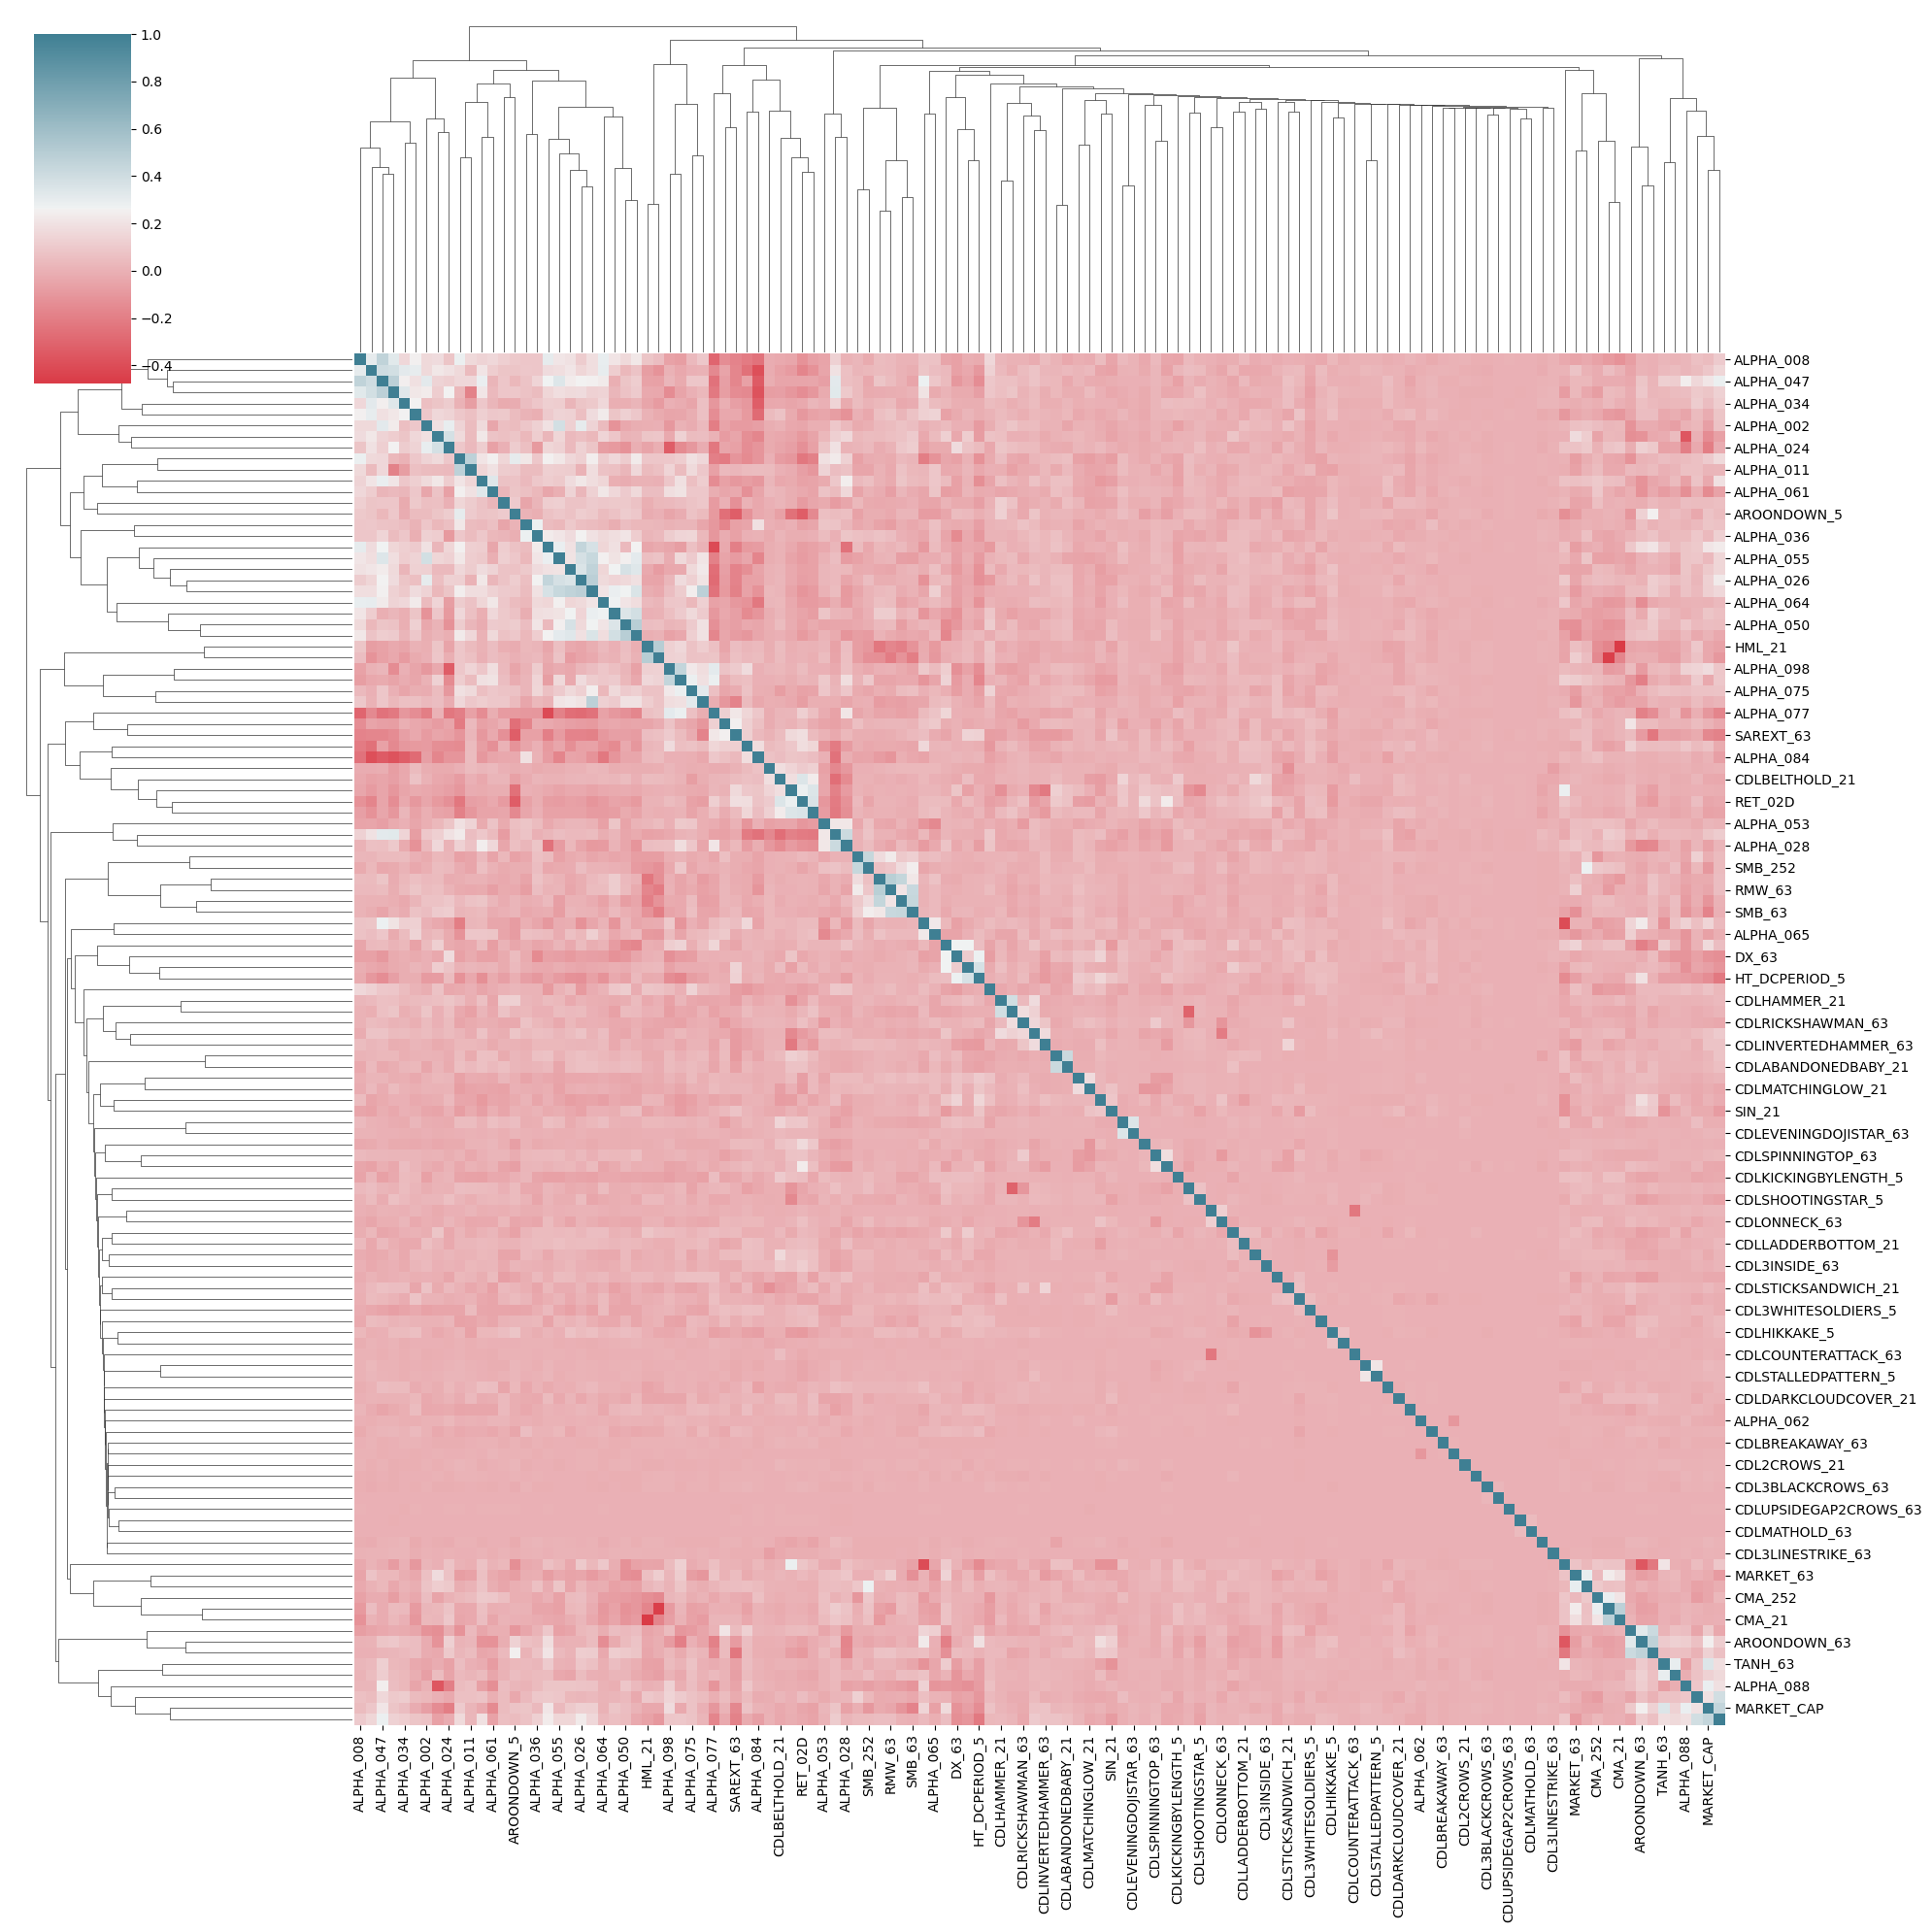

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns

# Assuming selected_corr_matrix is the variable containing your correlation matrix
# selected_corr_matrix = your_correlation_matrix_here

# Define the color map
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Create the clustermap
g = sns.clustermap(selected_corr_matrix, cmap=cmap, figsize=(20, 20))

plt.show()

In [12]:
# import pandas as pd
# import numpy as np

# # Create synthetic data
# np.random.seed(0)
# n = 100  # number of observations
# data = pd.DataFrame({
#     'ret_fwd_01d': np.random.normal(0, 1, n),  # forward 1-day returns
# })

# # Step 1: Create 5-quantile ranks
# data['target_quantile'] = pd.qcut(data['ret_fwd_01d'], q=5, labels=False)

# # Step 2: Primary Target (worth betting?)
# T = data['ret_fwd_01d'].std()
# data['primary_target'] = (data['ret_fwd_01d'].abs() > T).astype(int)

# # Step 3: Secondary Target (buy or sell?)
# # Buy if 5th quantile, sell if 1st quantile, otherwise no action
# data['secondary_target'] = np.where(data['primary_target'] == 1,
#                                     np.where(data['target_quantile'] == 4, 'Buy',
#                                              np.where(data['target_quantile'] == 0, 'Sell', 'No Action')),
#                                     'No Action')

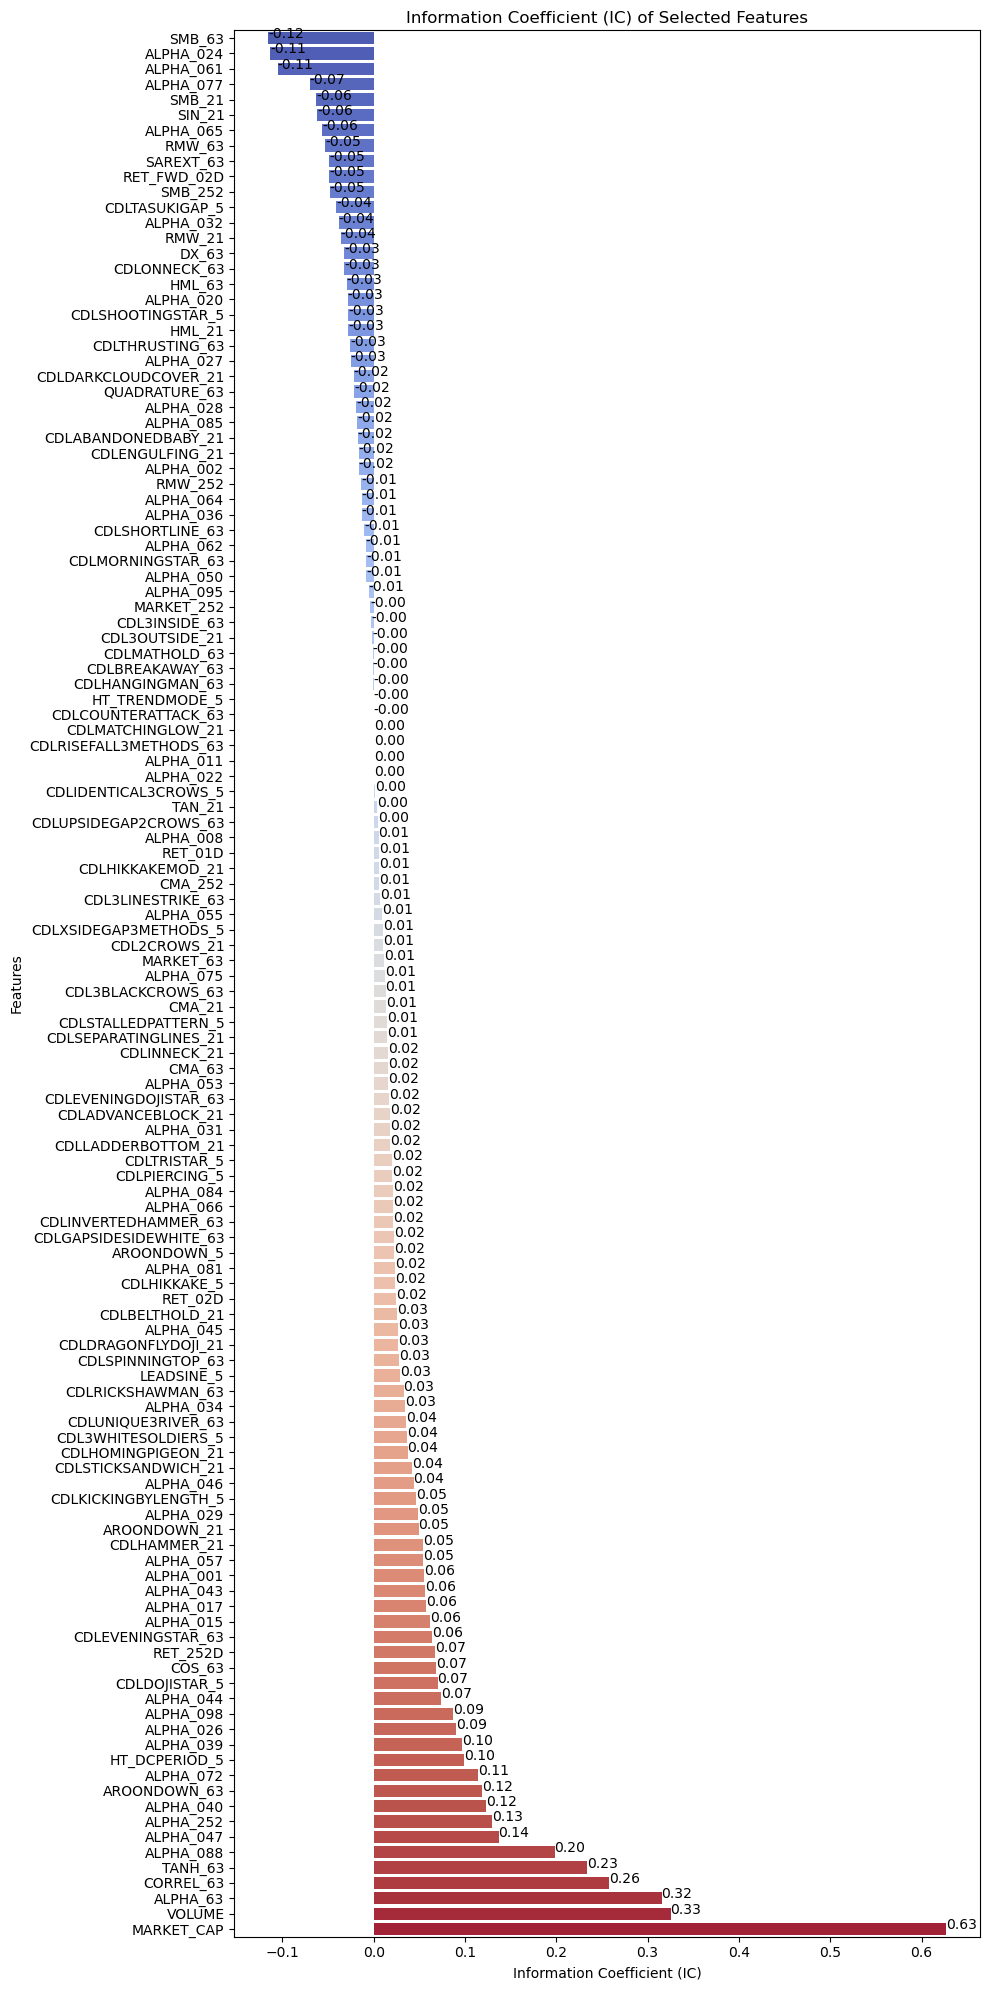

In [15]:
# Sort the Series for better visualization
sorted_ics = selected_ics.sort_values()

# Create the plot
plt.figure(figsize=(10, 20))  # Adjust the size as needed

sns.barplot(x=sorted_ics, y=sorted_ics.index, palette="coolwarm")

plt.xlabel('Information Coefficient (IC)')
plt.ylabel('Features')
plt.title('Information Coefficient (IC) of Selected Features')

# Annotate each bar with the actual IC value
for index, value in enumerate(sorted_ics):
    plt.text(value, index, f'{value:.2f}')

plt.tight_layout()

plt.show()

In [16]:
from utils import CustomBackwardMultipleTimeSeriesCV

cv_splits = CustomBackwardMultipleTimeSeriesCV(reduced_dataframe, \
        train_period_length=5, test_period_length=3, lookahead=1)

for train_idx, test_idx in cv_splits:
    # Here you can use train_idx and test_idx to get the training and validation data respectively
    train_data = reduced_dataframe[train_idx]
    print(train_data.shape)
    # val_data = reduced_dataframe[test_idx]
    # # Your training and validation code goes here...
    break

(14253, 129)


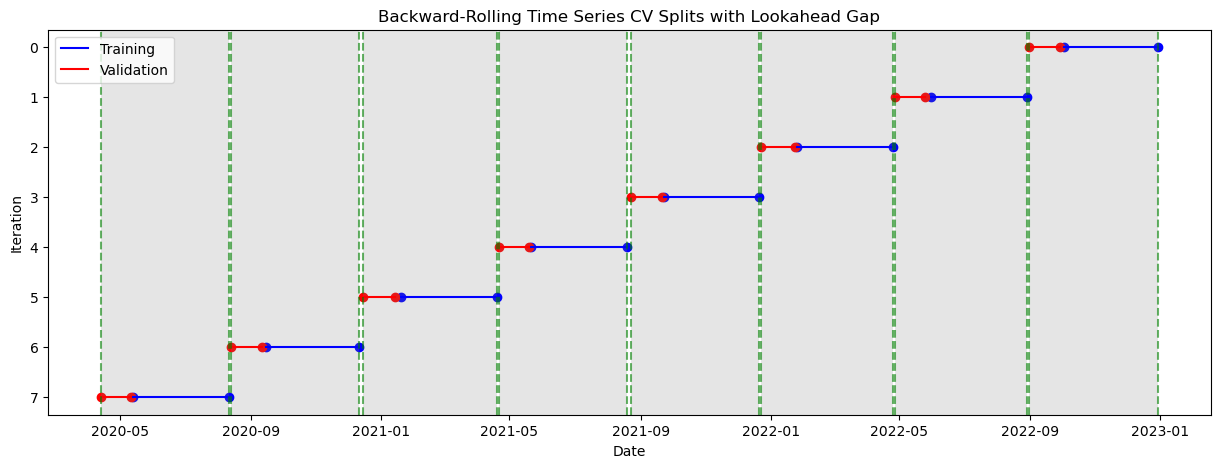

In [19]:
import matplotlib.pyplot as plt

def plot_time_series_cv_splits(dataframe, train_period_length=21*3, \
    test_period_length=21, lookahead=1, date_idx='date'):
    """
    Plots the train and validation windows for time series cross-validation.
    
    Parameters:
        dataframe: The data to be split.
        train_period_length: The number of business days in the training set.
        test_period_length: The number of business days in the validation set.
        lookahead: The gap between training and validation sets.
        date_idx: The name of the date index in the dataframe.
    """
    
    cv_splits = CustomBackwardMultipleTimeSeriesCV(dataframe, \
        train_period_length, test_period_length, lookahead, date_idx)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    for i, (train_idx, test_idx) in enumerate(cv_splits):
        # Get the date ranges
        train_dates = dataframe.index.get_level_values(date_idx)[train_idx]
        test_dates = dataframe.index.get_level_values(date_idx)[test_idx]

        ax.plot([train_dates[0], train_dates[-1]], [i, i], color='blue', label='Training' if i == 0 else "")
        ax.plot([test_dates[0], test_dates[-1]], [i, i], color='red', label='Validation' if i == 0 else "")
        ax.scatter([train_dates[0], train_dates[-1]], [i, i], color='blue')
        ax.scatter([test_dates[0], test_dates[-1]], [i, i], color='red')
        
        # Draw vertical dashed lines to represent the lookahead gap for every split
        gap_start = train_dates[-1]
        gap_end = test_dates[0]
        ax.axvline(x=gap_start, color='green', linestyle='--', alpha=0.6)
        ax.axvline(x=gap_end, color='green', linestyle='--', alpha=0.6)

        # Shade the lookahead gap
        ax.axvspan(gap_start, gap_end, facecolor='gray', alpha=0.2)
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Iteration')
    ax.set_title('Backward-Rolling Time Series CV Splits with Lookahead Gap')
    ax.legend(loc='best')
    plt.gca().invert_yaxis()  # invert y-axis to have the most recent data at the top
    plt.show()

# Now call the function to plot
plot_time_series_cv_splits(reduced_dataframe)